## Loading Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import adjusted_rand_score, silhouette_score
from scipy.stats import gaussian_kde
import umap
import os
import fcsparser

# -------------------------------------------- #

import cellCnn
from cellCnn.utils import loadFCS, ftrans, mkdir_p, get_items
from cellCnn.model import CellCnn
from cellCnn.plotting import plot_results



/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-24 18:57:46.829338: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-24 18:57:46.835704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 18:57:46.843549: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09

## Define WDIR and Paths

In [2]:
# Define input and output directories
WDIR = os.getcwd()
DATA_PATH = os.path.join(WDIR, 'data')
FCS_DATA_PATH = os.path.join(DATA_PATH, 'gated_NK')
DATA_LABELS_PATH = os.path.join(DATA_PATH, 'NK_fcs_samples_with_labels.csv')
MARKERS_PATH = os.path.join(DATA_PATH, 'NK_markers.csv')
OUTPUT_PATH = os.path.join(WDIR, 'output')

## Load Data

In [3]:
# Load fcs file labels
labels = pd.read_csv(DATA_LABELS_PATH)

# Load FCS data and add labels to the data for every file from the labels file 
def load_fcs_data(fcs_folder):
    data_list = []
    for filename in os.listdir(fcs_folder):
        if filename.endswith(".fcs"):
            path = os.path.join(fcs_folder, filename)
            meta, data = fcsparser.parse(path)
            data.head()
            data['filename'] = filename
            data['label'] = labels[labels['fcs_filename'] == filename]['label'].values[0]
            data_list.append(data)
    return pd.concat(data_list)

data = load_fcs_data(FCS_DATA_PATH)


/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/fcsparser/api.py:326: UserWarning: The first two characters were:
 \$. The last two characters were: \ 
Parser expects the same delimiter character in beginning and end of TEXT segment. This file may be parsed incorrectly!
  warnings.warn(msg)
/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/fcsparser/api.py:326: UserWarning: The first two characters were:
 \$. The last two characters were: \ 
Parser expects the same delimiter character in beginning and end of TEXT segment. This file may be parsed incorrectly!
  warnings.warn(msg)
/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/fcsparser/api.py:326: UserWarning: The first two characters were:
 \$. The last two characters were: \ 
Parser expects the same delimiter character in beginning and end of TEXT segment. This file may be parsed incorrectly!
  warnings.warn(msg)
/opt/miniconda3/envs/single-cell-playground/lib/p

In [4]:
# count the number of row by label
data['label'].value_counts()

label
0    140007
1    121586
Name: count, dtype: int64

In [15]:
data.shape

(261593, 37)

In [5]:
## Filter data by the markers of interest
data_labels = data['label']
markers = ['CD3', 'CD27', 'CD19', 'CD4', 'CD8', 'CD57', '2DL1-S1', 'TRAIL', '2DL2-L3-S2',
           'CD16', 'CD10', '3DL1-S1', 'CD117', '2DS4', 'ILT2-CD85j', 'NKp46', 'NKG2D',
           'NKG2C', '2B4', 'CD33', 'CD11b', 'NKp30', 'CD122', '3DL1', 'NKp44', 'CD127', '2DL1',
           'CD94', 'CD34', 'CCR7', '2DL3', 'NKG2A', 'HLA-DR', '2DL4', 'CD56', '2DL5', 'CD25']

data = data[markers]
data.head()

,CD3,CD27,CD19,CD4,CD8,CD57,2DL1-S1,TRAIL,2DL2-L3-S2,CD16,...,CD94,CD34,CCR7,2DL3,NKG2A,HLA-DR,2DL4,CD56,2DL5,CD25
0,30.896135,8.150837,-0.962388,9.582445,215.682922,-0.806226,-0.458802,-0.965842,-0.082399,-0.390968,...,3.798466,-0.429973,-0.974881,-0.068205,-0.704857,-0.156821,-0.378355,71.991722,-0.447079,7.857432
1,-0.189011,-0.353177,1.458649,-0.385973,5.788373,6.435588,-0.641600,-0.383107,-0.895022,120.354599,...,-0.416407,-0.500214,-0.292969,10.080403,-0.474103,-0.135527,-0.696942,103.947952,4.817307,2.433834
2,3.178262,-0.741575,-0.475677,-0.935496,94.860466,-0.009882,12.896515,-0.596726,-0.009475,30.690014,...,1.060482,-0.811749,-0.514740,-0.036100,1.071799,0.369903,-0.198578,-0.651031,-0.378486,-0.019282
3,-0.031603,-0.886016,-0.088003,-0.949939,-0.064042,1.881515,-0.182357,-0.427589,2.534402,161.095657,...,3.416013,10.453577,-0.410310,-0.159703,17.858381,21.198469,1.066118,87.349487,0.132842,-0.278989
4,1.477983,9.030165,-0.813333,-0.824298,-0.345992,-0.928714,-0.371814,-0.517228,-0.729594,233.910950,...,14.516968,-0.067356,-0.985090,-0.652094,-0.176750,-0.438034,-0.662665,96.763748,8.387317,-0.985157


## EDA

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
# Plot histograms for selected markers
select_markers = ['CD3', 'CD27', 'CD19']  # Replace with the marker names in your dataset

def plot_hist(data, select_markers, markers_per_grid=10, cap_outliers=True):
    num_grids = math.ceil(len(select_markers) / markers_per_grid)
    
    for i in range(num_grids):
        # Get the subset of markers
        markers_subset = select_markers[i * markers_per_grid:(i + 1) * markers_per_grid]
        
        # Handle outliers by capping extreme values
        if cap_outliers:
            data_capped = data[markers_subset].apply(lambda x: np.clip(x, a_min=np.percentile(x, 1), a_max=np.percentile(x, 99)))
        else:
            data_capped = data[markers_subset]
        
        # Log-transform the intensity values
        data_log = data_capped.apply(np.log1p)  # log1p to safely handle zeros
        data_long = data_log.melt(var_name='Marker', value_name='Log Intensity')
        
        # Create the FacetGrid with log-log scale and dynamic binning
        g = sns.FacetGrid(data_long, col='Marker', col_wrap=5, height=3, aspect=1.2, palette="husl")
        g.map(sns.histplot, 'Log Intensity', bins=70, kde=True, kde_kws={'bw_adjust': 0.8}, color='blue', alpha=0.3)
        
        # Apply log scale to the y-axis for frequency
        for ax, marker in zip(g.axes.flat, markers_subset):
            ax.set_yscale('log')
            # Set x-axis limits to focus on meaningful intensity ranges
            ax.set_xlim(-2, 2)
            
            # Add statistical annotation (mean)
            mean_intensity = np.mean(data[marker].apply(np.log1p))
            ax.axvline(mean_intensity, color='red', linestyle='--')
            ax.text(mean_intensity, ax.get_ylim()[1]*0.9, f'Mean: {mean_intensity:.2f}', color='red')
        
        # Set titles and labels
        g.set_titles('{col_name}')
        g.set_axis_labels('Log(Intensity)', 'Log(Frequency)')
        
        # Tight layout for better spacing
        plt.tight_layout()
        plt.show()

# Test plot
#plot_hist(data, select_markers)

In [7]:
# Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

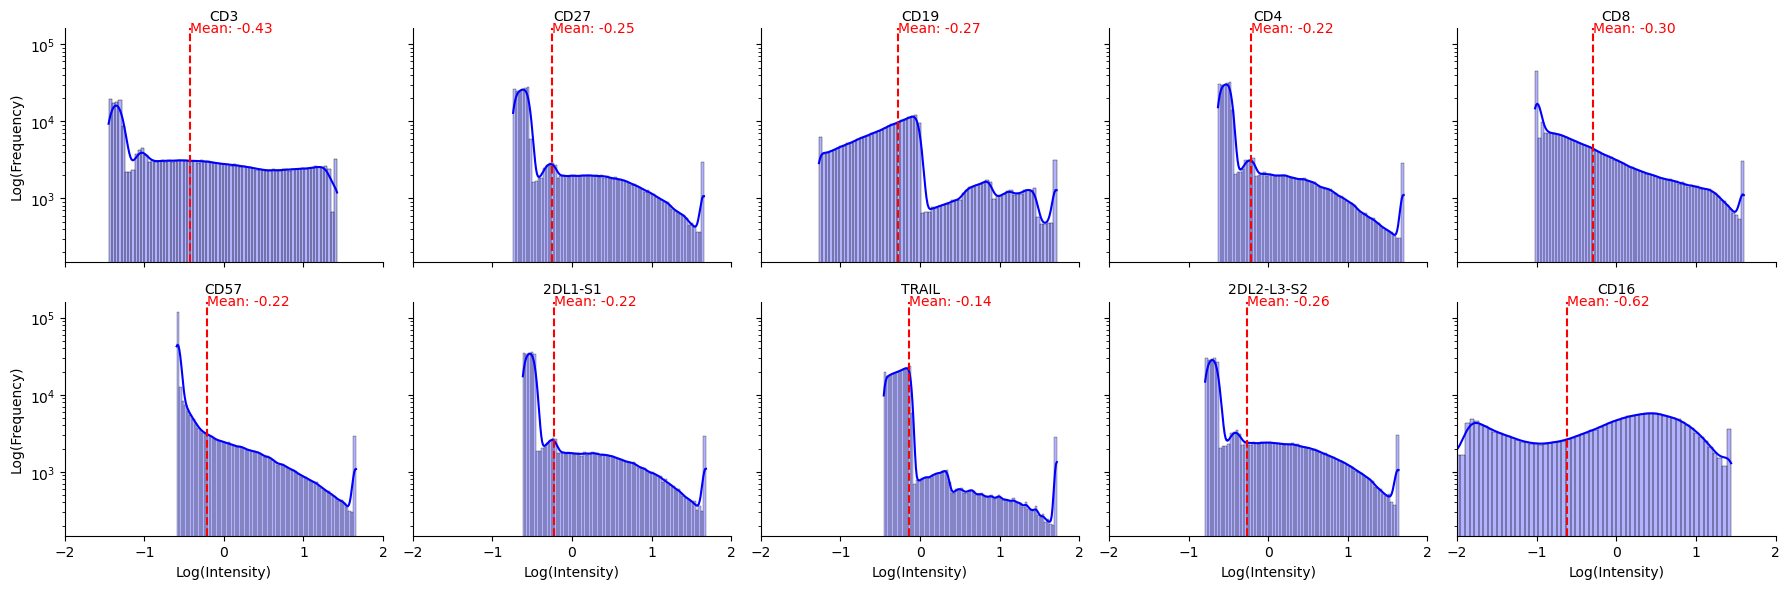

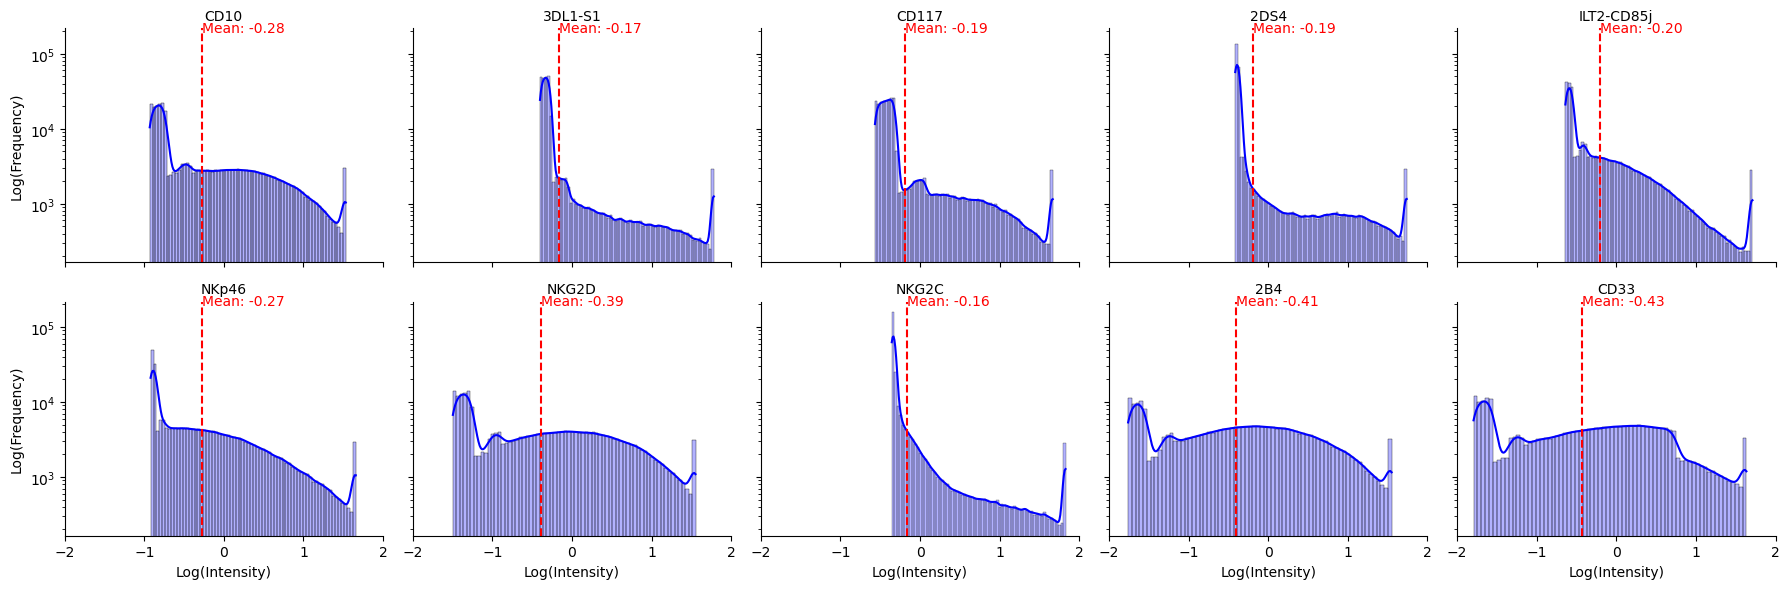

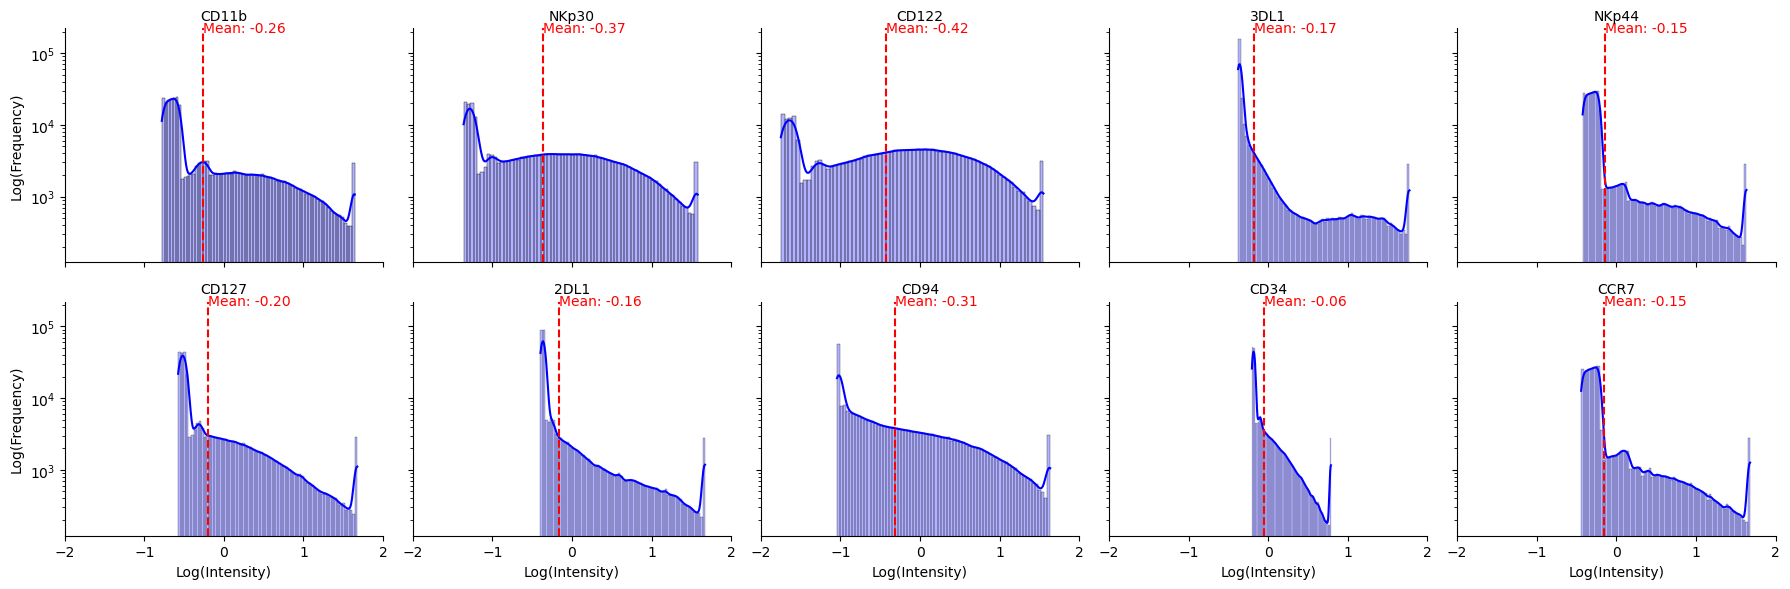

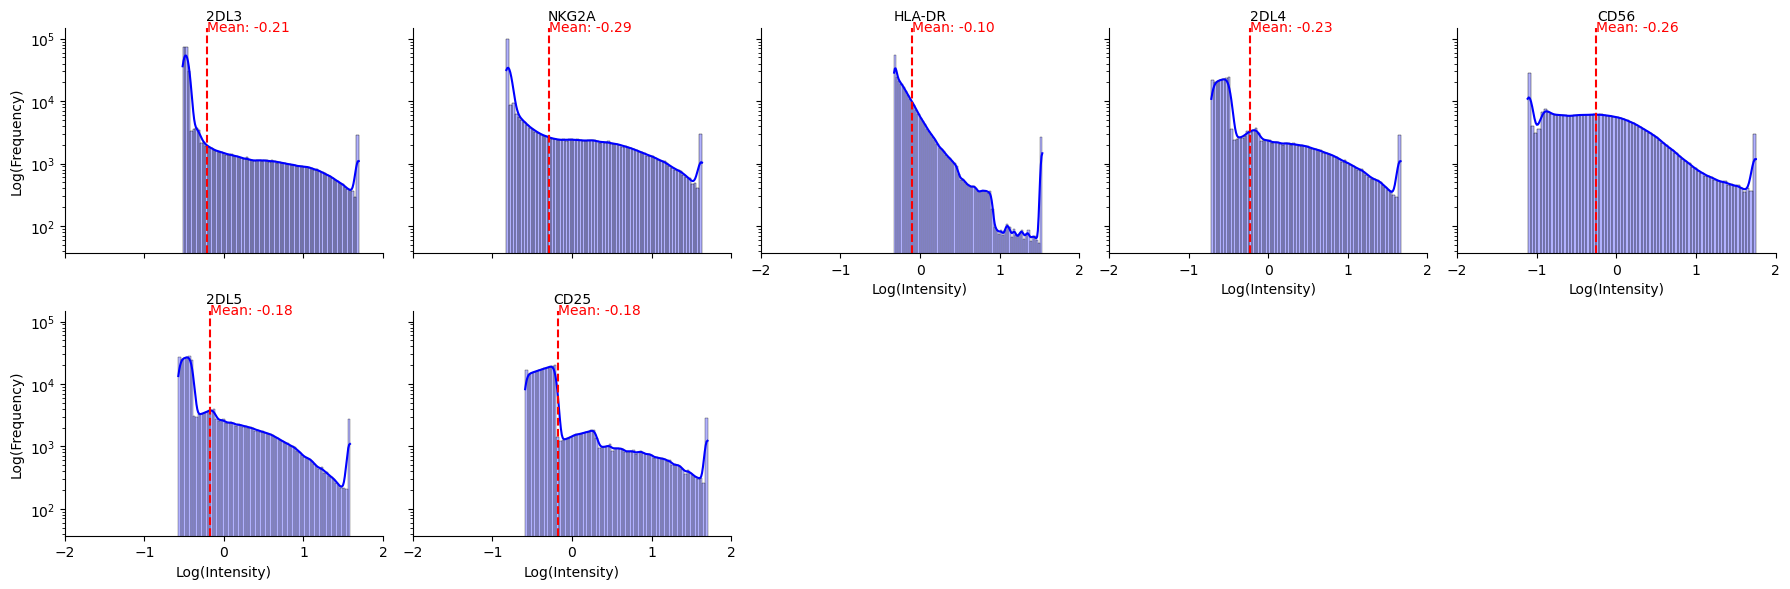

In [16]:
plot_hist(pd.DataFrame(scaled_data, columns=data.columns), markers)

In [8]:
def plot_density(embedding, method):
    # Extract the components
    x = embedding[:, 0]
    y = embedding[:, 1]

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort points by density for better visualization
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    plt.figure(figsize=(10, 6))

    # Scatter plot for the points
    scatter = plt.scatter(x, y, c=z, cmap='viridis', s=5)

    # Add KDE contours
    sns.kdeplot(x=x, y=y, levels=5, color='black', linewidths=1, fill=True, alpha=0.2, bw_adjust=0.7)

    # Add colorbar
    plt.colorbar(scatter, label='Density')

    plt.title(f'{method} Plot with Density Contours')
    plt.xlabel(f'{method} Component 1')
    plt.ylabel(f'{method} Component 2')
    plt.show()

### PCA

In [9]:
def apply_pca(data, n_components=15):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(data)
    return pca_result

# Apply PCA
pca_result = apply_pca(scaled_data)

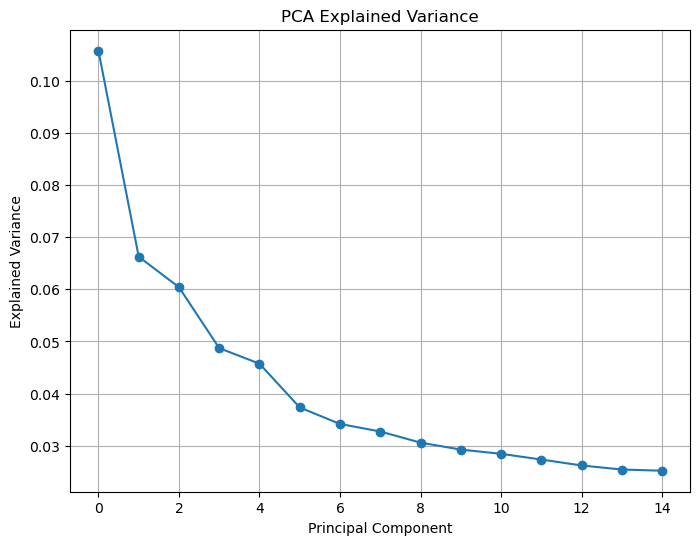

In [72]:
## plot pca variance explained by each component 
def plot_pca_variance(data, n_components=10):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(data)

    plt.figure(figsize=(8, 6))
    plt.plot(pca.explained_variance_ratio_, marker='o')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True)
    plt.show()

plot_pca_variance(scaled_data, n_components=15)

/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


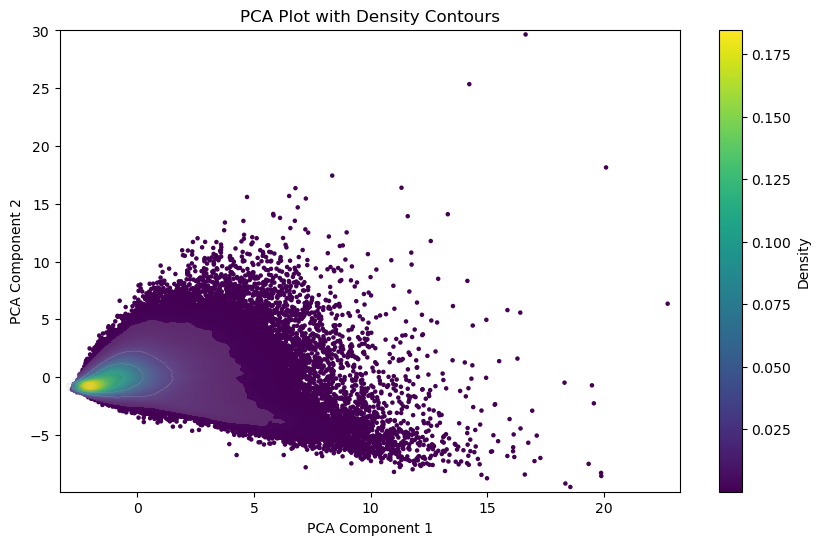

In [10]:
plot_density(embedding=pca_result, method="PCA")

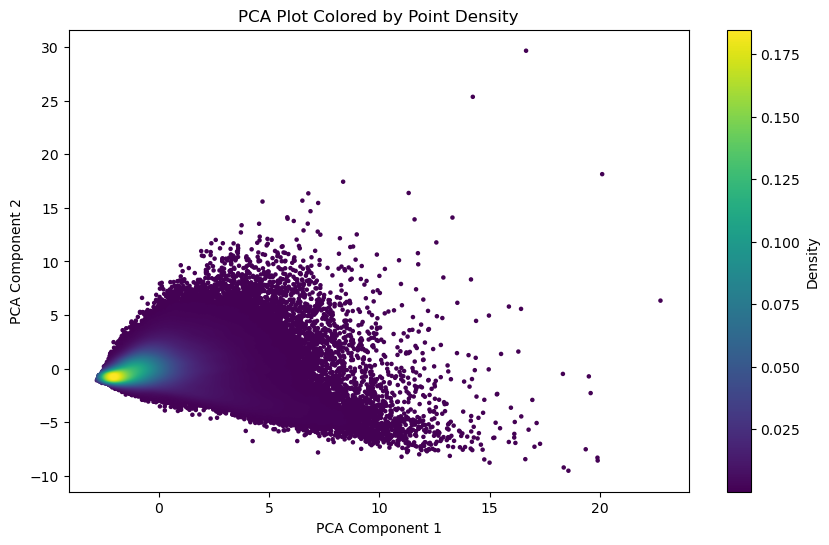

In [38]:
## Plotting the PCA plot colored by point density
# Extract the PCA components
x = pca_result[:, 0]
y = pca_result[:, 1]

# Calculate the point density
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort points by density for better visualization
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=z, cmap='viridis', s=5)
plt.colorbar(label='Density')
plt.title('PCA Plot Colored by Point Density')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

### t-SNE

In [73]:
def apply_tsne(data, perplexity=30, n_components=2, learning_rate=200, n_iter=1000):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    tsne_result = tsne.fit_transform(data)
    return tsne_result

# Apply t-SNE
tsne_result = apply_tsne(pca_result)

/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


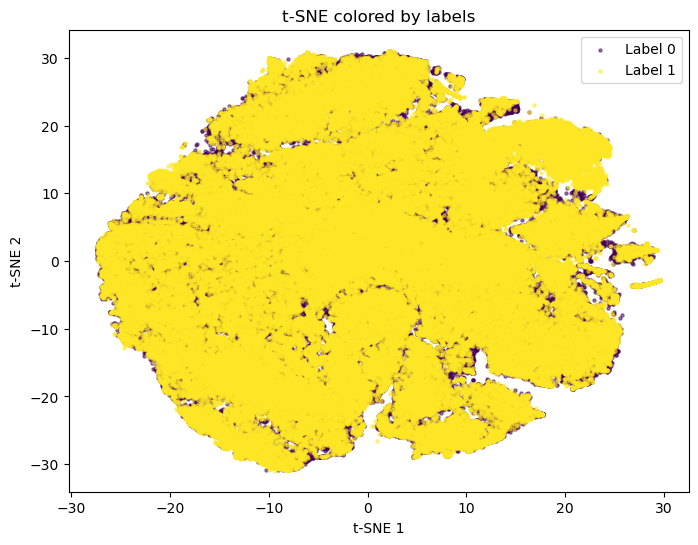

In [76]:
# Visualize t-SNE colored by labels
def plot_tsne(tsne_result, labels):
    unique_labels = np.unique(labels)
    colors = plt.get_cmap('viridis', len(unique_labels))

    plt.figure(figsize=(8, 6))

    for i, lbl in enumerate(unique_labels):
        idx = labels == lbl
        plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=f'Label {lbl}', alpha=0.5, color=colors(i), s=5)

    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    plt.title('t-SNE colored by labels')
    plt.show()
    
plot_tsne(tsne_result, data_labels)

/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


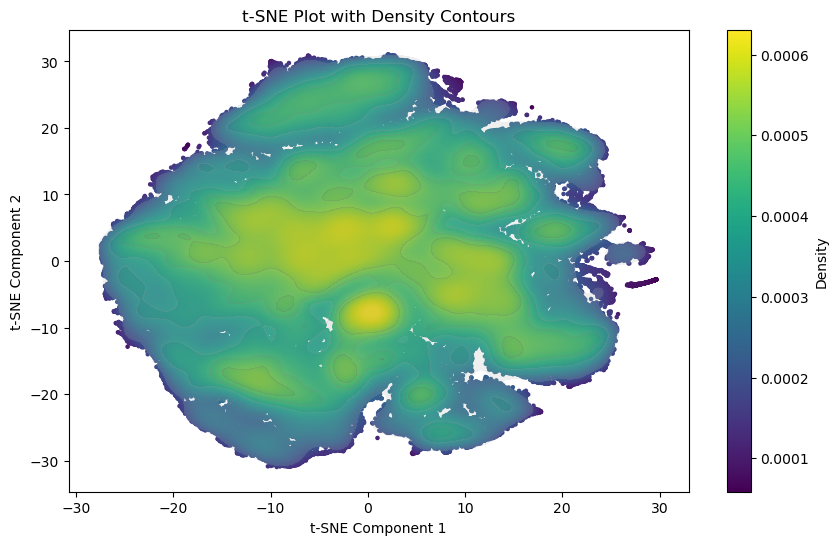

In [78]:
# Example for t-SNE
plot_density(embedding=tsne_result, method="t-SNE")

### UMAP

In [11]:
def apply_umap(data, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean'):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric)
    umap_result = reducer.fit_transform(data)
    return umap_result
    
# Apply UMAP
umap_result = apply_umap(pca_result)

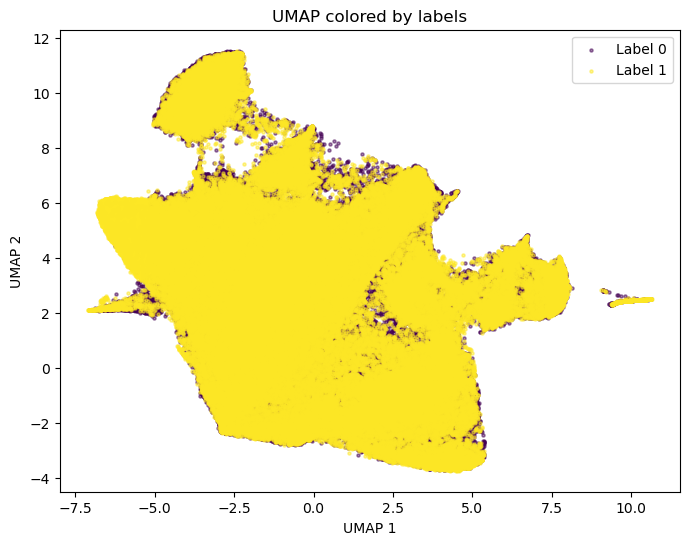

In [80]:
def plot_umap(umap_result, labels):
    unique_labels = np.unique(labels)
    colors = plt.get_cmap('viridis', len(unique_labels))

    plt.figure(figsize=(8, 6))

    for i, lbl in enumerate(unique_labels):
        idx = labels == lbl
        plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=f'Label {lbl}', alpha=0.5, color=colors(i), s=5)

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend()
    plt.title('UMAP colored by labels')
    plt.show()

plot_umap(umap_result, data_labels)

/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


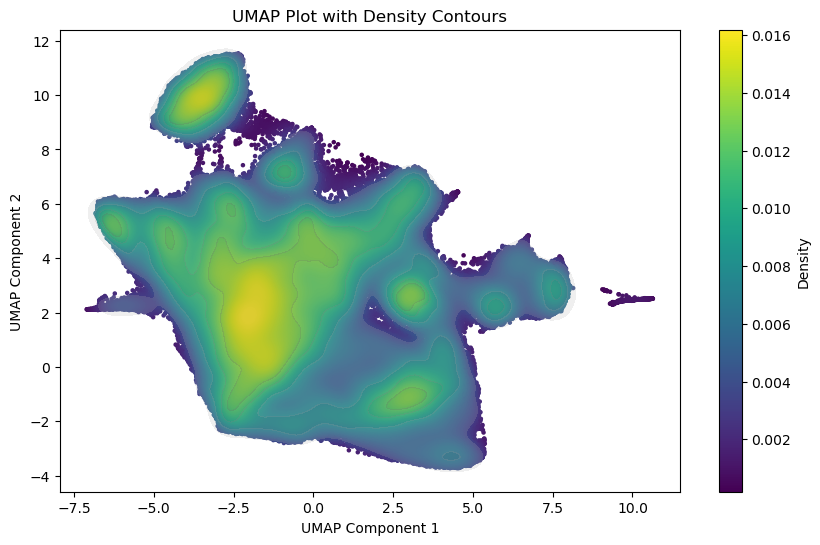

In [81]:
plot_density(embedding=umap_result, method="UMAP")

## Comparing the Methods

In [ ]:
# Calculate Silhouette Scores for PCA, t-SNE, and UMAP
def calculate_silhouette(data, labels):
    return silhouette_score(data, labels)

# Using PCA, t-SNE, and UMAP results as labels for silhouette score
pca_silhouette = calculate_silhouette(scaled_data, pca_result[:, 0])
tsne_silhouette = calculate_silhouette(scaled_data, tsne_result[:, 0])
umap_silhouette = calculate_silhouette(scaled_data, umap_result[:, 0])

print(f"Silhouette score for PCA: {pca_silhouette}")
print(f"Silhouette score for t-SNE: {tsne_silhouette}")
print(f"Silhouette score for UMAP: {umap_silhouette}")


## Clustering

### K-means

In [108]:
from sklearn.cluster import KMeans

def apply_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(data)
    return kmeans_labels

# Apply KMeans
kmeans_labels = apply_kmeans(pca_result, n_clusters=6)


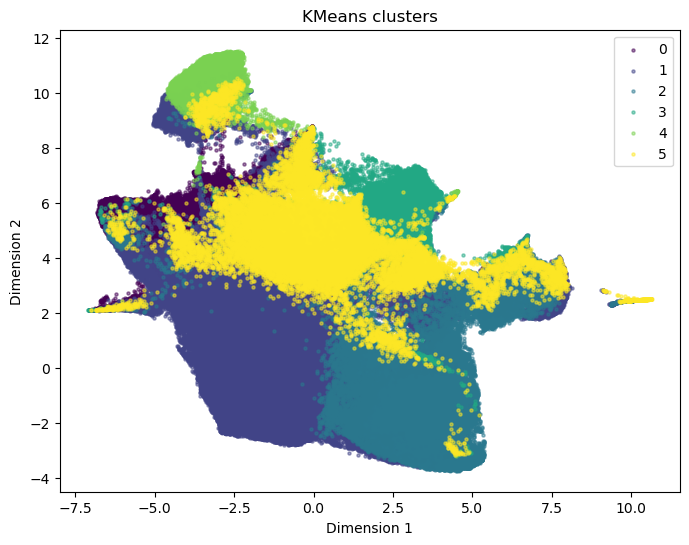

In [109]:
## Plot KMeans clusters
def plot_kmeans(data, labels):
    unique_labels = np.unique(labels)
    colors = plt.get_cmap('viridis', len(unique_labels))

    plt.figure(figsize=(8, 6))

    for i, lbl in enumerate(unique_labels):
        idx = labels == lbl
        plt.scatter(data[idx, 0], data[idx, 1], label=f'{lbl}', alpha=0.5, color=colors(i), s=5)

    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.title('KMeans clusters')
    plt.show()

plot_kmeans(umap_result, kmeans_labels)

### Hierarchical

In [14]:
from scipy.cluster.hierarchy import linkage, fcluster

def apply_hierarchical(data, n_clusters):
    Z = linkage(data, method='ward')
    hierarchical_labels = fcluster(Z, n_clusters, criterion='maxclust')
    return hierarchical_labels

# Apply Hierarchical Clustering
hierarchical_labels = apply_hierarchical(pca_result, n_clusters=5)

MemoryError: Unable to allocate 255. GiB for an array with shape (34215318028,) and data type float64

### Leiden

In [12]:
import leidenalg as la
import igraph as ig

def apply_leiden(data, n_clusters, knn=15):
    # Convert data to a KNN graph using iGraph
    n_cells = data.shape[0]
    graph = ig.Graph()
    graph.add_vertices(n_cells)

    for i in range(n_cells):
        distances = np.linalg.norm(data - data[i], axis=1)
        neighbors = np.argsort(distances)[1:knn+1]
        for neighbor in neighbors:
            graph.add_edge(i, neighbor)

    # Apply Leiden algorithm
    partition = la.find_partition(graph, la.ModularityVertexPartition)
    leiden_labels = np.array(partition.membership)
    return leiden_labels

# Apply Leiden Clustering
leiden_labels = apply_leiden(scaled_data, n_clusters=2)


ModuleNotFoundError: No module named 'leidenalg'

### Comparing the Methods

In [ ]:
true_labels = data_labels

# Adjusted Rand Index
kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)
hierarchical_ari = adjusted_rand_score(true_labels, hierarchical_labels)
leiden_ari = adjusted_rand_score(true_labels, leiden_labels)

# Silhouette Score
kmeans_silhouette = silhouette_score(scaled_data, kmeans_labels)
hierarchical_silhouette = silhouette_score(scaled_data, hierarchical_labels)
leiden_silhouette = silhouette_score(scaled_data, leiden_labels)

# Print Results
print(f"k-means ARI: {kmeans_ari}, Silhouette: {kmeans_silhouette}")
print(f"Hierarchical ARI: {hierarchical_ari}, Silhouette: {hierarchical_silhouette}")
print(f"Leiden ARI: {leiden_ari}, Silhouette: {leiden_silhouette}")


## Comparative Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import fcsparser
import umap
from sklearn.decomposition import PCA
import tensorflow as tf
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Feature prep

In [9]:
import os
from sklearn.preprocessing import StandardScaler


# Split into features and target (assuming the target is in the 'cell_type' column)
X = scaled_data
y = data_labels # replace with actual label

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

In [10]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_accuracy}")


Logistic Regression Accuracy: 0.6640417439171238


### SVM

In [13]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy}")

SVM Accuracy: 0.7399606261587569


### Random Forest

In [23]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy}")


Random Forest Accuracy: 0.7431334696764081
